# Loading modules

In [1]:
import xarray as xr
import numpy as np
import sys
from pathlib import Path
from glob import glob
import gc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../../../')
"""
local scripts, if loading from a different directory include that with a '.' between
directory name and script name
"""
from tropical_PODs.PODs.POD_utils import limit_files_to_select_years
from tropical_PODs.PODs.POD_utils import calculate_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.plotting_utils import plot_one_variable_binned_ivar
from tropical_PODs.PODs.plotting_utils import plot_two_variables_binned_ivar
from tropical_PODs.PODs.POD_utils import numerical_plume_model
from tropical_PODs.PODs.POD_utils import calculate_CAPE

# Set path of home directory
home = str(Path.home())
print('Home directory is:', home)

Home directory is: /Users/lure7597


# Define input directories and file names

In [2]:
# Years to analyze
start_year = (2024)
end_year = (2024)

################
###.  ERA5.  ###
################

# Set paths for ERA5/IMERG data   
era5_path   = '/Volumes/TOSHIBA/ERA5/PODs_data/'
imerg_path  = '/Volumes/TOSHIBA/IMERG/2024_May-June/'

# Atmosphere
ifile_specific_humidity = era5_path + '2024-mayjun-hus.nc'  # ERA5 Specific Humidity
ifile_temperature       = era5_path + '2024-mayjun-temp.nc' # ERA5 Temperature
ifile_surface_pressure  = era5_path + '2024-mayjun-psfc.nc' # ERA5 Surface Pressure
ifile_precipitation     = imerg_path + '3B-DAY*'            # IMERG Precipitation

#ifile_specific_humidity = '../../../tropical_PODs/data/shum.2p5.*.nc' # ERA5 Specific Humidity
#ifile_temperature = '../../../tropical_PODs/data/air.2p5.*.nc' # ERA5 Temperature
#ifile_surface_pressure = '../../../tropical_PODs/data/pres.sfc.2p5.*.nc' # ERA5 Surface Pressure
#ifile_precipitation = '../../../tropical_PODs/data/3B-DAY.MS.MRG.3IMERG.V06.*' # IMERG Precipitation

# Land
ifile_land_frac = era5_path + '2024-mayjun-land-sea-mask.nc'   # ERA5 Land Fraction 
#ifile_land_frac = '../../../tropical_PODs/data/land_sea_mask.erai.2p5.nc' # ERAi Land Fraction 


# Define regions to average over

In [3]:
# Current region options are: 
    #-> AS  = Arabian Sea 
    #-> BoB = Bay of Bengal
    #-> all = whole data domain

region_key = 'all'

# Define square bounding area for Arabian Sea ('AS') #
as_latlow   = 5
as_lathigh  = 20
as_lonlow   = 50
as_lonhigh  = 78

# Define square bounding area for Bay of Bengal ('BoB') #
bob_latlow  = 5
bob_lathigh = 22
bob_lonlow  = 80
bob_lonhigh = 100

# Define functions & key options

In [4]:
###################################################################################################
# Define a function to test for different variable labelling options if using a range of datasets #
###################################################################################################

def find_first_valid_key(data, key_options):
    """
    Returns the first valid key found in 'data' from the provided 'key_options' list.
    
    Parameters:
        data (dict-like): Dictionary, xarray.Dataset, or similar object.
        key_options (list): List of string keys to check.

    Returns:
        str or None: The first matching key, or None if none found.
    """
    for key in key_options:
        try:
            _ = data[key]
            print(f"✅ Found {key_options[0]} using key: '{key}'")
            return key
        except KeyError:
            pass
            #print(f"❌ KeyError for: '{key}'")
    print("⚠️ No valid key found in the list.")
    return 

# Define key options for variables #
time_options  = ['time', 'TIME', 'Times', 'valid_time']
level_options = ['level', 'pressure_level']
lat_options  = ['latitude',  'latitudes',  'lat', 'lats', 'LAT', 'LATITUDE',  'XLAT']
lon_options  = ['longitude', 'longitudes', 'lon', 'lons', 'LON', 'LONGITUDE', 'XLON']
lsm_options  = ['land_sea_mask', 'lsm', 'land-sea-mask', 'LandSeaMask', 'LANDMASK', 'landmask', 'mask']
psfc_options = ['surface_pressure', 'psfc', 'PSFC', 'ps', 'PS', 'surface_pres', 'sp', 'pres']

# note that WRF outputs water vapor mixing ratio (w), which needs to be converted to specific humidity, q = w/(1+w)
spec_humidity_options = ['specific_humidity','q', 'Q', 'hus', 'HUS', 'QVAPOR', 'qvapor', 'qv', 'shum']

temp_options = ['temperature', 'TEMPERATURE', 't', 'T', 'temp', 'TEMP', 'air_temperature', 'tas', 'TAS', 'air']
precip_options = ['precipitation', 'pr', 'precip', 'tp'] # how to add RAINC and RAINNC for WRF

################################################################################
# Define a function to find the closest value in a 1D array to specified value #
################################################################################

def find_nearest(array1d, value):

    array = np.asarray(array1d)
    index = (np.abs(array - value)).argmin()
    return index, array[index]
    

# Define output directories

In [5]:
# Output directory for datasets
#odir_datasets = '../../../tropical_PODs/examples/ofiles_examples/'
odir_datasets = '../../../tropical_PODs/examples/ofiles_' + region_key + '/'

# Output directory for datasets
#odir_plots = '../../../tropical_PODs/examples/oplots_examples/'
odir_plots = '../../../tropical_PODs/examples/oplots_' + region_key + '/'


# Driver for calculations

In [6]:
# Define constants
    
g = 9.8 # [m s^-2]

#########################################
# Define paths of files we wish to load #
#########################################
    
# glob expands paths with * to a list of files, like the unix shell #

paths_specific_humidity = glob(ifile_specific_humidity)
paths_temperature = glob(ifile_temperature)
paths_surface_pressure = glob(ifile_surface_pressure)
paths_precipitation = glob(ifile_precipitation)
paths_land = glob(ifile_land_frac)
        
for year in range(start_year, end_year + 1):
        
    print(year)

    # Define year strings #

    previous_year_string = str(year - 1)
    current_year_string = str(year)
    next_year_string = str(year + 1)
            
    while len(previous_year_string) < 4:
        previous_year_string = '0' + previous_year_string
                
    while len(current_year_string) < 4:
        current_year_string = '0' + current_year_string
                
    while len(next_year_string) < 4:
        next_year_string = '0' + next_year_string

    # Limit paths to previous, current, and next year #

    year_limited_paths_specific_humidity = limit_files_to_select_years(paths_specific_humidity, range(year - 1, year + 2))
    year_limited_paths_temperature = limit_files_to_select_years(paths_temperature, range(year - 1, year + 2))
    year_limited_paths_surface_pressure = limit_files_to_select_years(paths_surface_pressure, range(year - 1, year + 2))
    year_limited_paths_precipitation = limit_files_to_select_years(paths_precipitation, range(year - 1, year + 2))

    print(len(year_limited_paths_specific_humidity))
     
    #####################
    ####  Load Data  ####
    #####################

    # Data is "lazy loaded", nothing is actually loaded until we "look" at data in some way #
    dataset_specific_humidity = xr.open_mfdataset(year_limited_paths_specific_humidity, combine="by_coords")
    dataset_temperature = xr.open_mfdataset(year_limited_paths_temperature, combine="by_coords")
    dataset_surface_pressure = xr.open_mfdataset(year_limited_paths_surface_pressure, combine="by_coords")
    dataset_precipitation = xr.open_mfdataset(year_limited_paths_precipitation, combine="by_coords")
    dataset_land = xr.open_dataset(paths_land[0])

    #####################
    ####  Load Data  ####
    #####################

    # Make data arrays, loading only the year of interest - can also subset lats/lons here as needed, e.g. lat = slice(10, -10) #
    print('For ERA5 data:')
    level_key      = find_first_valid_key(dataset_temperature, level_options)
    time_key_era5  = find_first_valid_key(dataset_surface_pressure, time_options)

    lat_key_era5 = find_first_valid_key(dataset_surface_pressure, lat_options)
    full_lat = dataset_surface_pressure[lat_key_era5]

    lon_key_era5 = find_first_valid_key(dataset_surface_pressure, lon_options)
    full_lon = dataset_surface_pressure[lon_key_era5]

    lsm_key = find_first_valid_key(dataset_land, lsm_options)
    land_sea_mask = dataset_land[lsm_key] 

    psfc_key = find_first_valid_key(dataset_surface_pressure, psfc_options)
    PS = dataset_surface_pressure[psfc_key].sel({time_key_era5: slice(previous_year_string+'-12-31', next_year_string+'-01-01')}) # [Pa]

    spec_humidity_key = find_first_valid_key(dataset_specific_humidity, spec_humidity_options)
    Q = dataset_specific_humidity[spec_humidity_key].sel({time_key_era5: slice(previous_year_string+'-12-31', next_year_string+'-01-01')}) # [Kg/Kg]

    temp_key = find_first_valid_key(dataset_temperature, temp_options)
    T = dataset_temperature[temp_key].sel({time_key_era5: slice(previous_year_string+'-12-31', next_year_string+'-01-01')}) # [K]

    print('For IMERG data:')
    time_key_imerg = find_first_valid_key(dataset_precipitation, time_options)
    lat_key_imerg  = find_first_valid_key(dataset_precipitation, lat_options)
    lon_key_imerg  = find_first_valid_key(dataset_precipitation, lon_options)

    precip_key = find_first_valid_key(dataset_precipitation, precip_options)
    precipitation_rate = dataset_precipitation[precip_key].sel({time_key_imerg: slice(previous_year_string+'-12-31', next_year_string+'-01-01')}) #* (24) # Currently [mm/hr]. Convert to [mm/day]

    #########################
    ####  Convert Units  ####
    #########################
    
    # Want surface pressure in Pa, specific humidity in Kg/Kg, temperature in K and precipitation rate in mm/day #
    #from metpy.units import units
    if PS.units == 'Pa':
        print('surface pressure units in Pa as required')
    elif PS.units == 'hPa':
        print('converting surface pressure units from hPa to Pa')
        PS = PS*100.
        PS.attrs['units'] = 'hPa'
    else:
        print('unknown surface pressure units need conversion to Pa: ' + PS.units)

    if Q.units == 'kg kg**-1' or Q.units == 'kg/kg' or Q.units == 'kg kg-1':
        print('specific humidity units in Kg/Kg as required')
    elif Q.units == 'g kg**-1' or Q.units == 'g/kg' or Q.units == 'g kg-1':
        print('converting specific humidity units from g/Kg to Kg/Kg')
        Q = Q/1000.
        Q.attrs['units'] = 'kg kg-1'
    else:
        print('unknown specific humidity units need conversion to Kg/Kg: ' + Q.units)

    if T.units == 'K':
        print('temperature units in K as required')
    elif T.units == 'C':
        print('converting temperature units from C to K')
        T = T + 273.15
        T.attrs['units'] = 'K'
    else:
        print('unknown temperature units need conversion to K: ' + T.units)

    if precipitation_rate.units == 'mm/day' or precipitation_rate.units == 'mm day-1':
        print('precipitation rate units in mm/day as required')
    elif precipitation_rate.units == 'mm/hour' or precipitation_rate.units == 'mm hour-1':
        print('converting precipitation rate units from mm/hour to mm/day')
        precipitation_rate = precipitation_rate * 24
        precipitation_rate.attrs['units'] = 'mm/day'
    else:
        print('unknown precipitation rate units need conversion to mm/day: ' + precipitation_rate.units)

    # Actually load data #
    land_sea_mask.load()
    PS.load()
    Q.load()
    T.load()
    precipitation_rate.load()

    # Clean up environment #
    gc.collect();
 
    ################################
    ####  Average Data to Daily ####
    ################################
    
    ###   Test for Averaging Method   ###
            
    #PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).plot()
    #print(PS.resample(time='1D').mean('time').sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75))
    #print(PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).mean('time'))
    #print(PS.resample(time='1D').mean('time').sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).values == PS.sel(time=slice('1998-01-01','1998-01-01'),lat=5,lon=75).mean('time').values)
    
    ###   Perform Averaging   ###
            
    # no change for my data as already daily data from ERA5/IMERG
    Q = Q.resample({time_key_era5: '1D'}).mean(time_key_era5)
    T = T.resample({time_key_era5: '1D'}).mean(time_key_era5)
    PS = PS.resample({time_key_era5: '1D'}).mean(time_key_era5)
    precipitation_rate = precipitation_rate.resample({time_key_imerg: '1D'}).mean(time_key_imerg)

    # check if IMERG time was saved as datetime (desired) or CFtime (need to convert to datetime)
    if precipitation_rate[time_key_imerg].dtype == 'datetime64[ns]':
        pass
    elif precipitation_rate[time_key_imerg].dtype == 'object':
        precipitation_rate[time_key_imerg] = precipitation_rate.indexes[time_key_imerg].to_datetimeindex() 

    # ### Update time to reflect center of daily average   ###
    
    # PS = PS.assign_coords({'time':PS['time']+pd.to_timedelta(10.5, unit='H')})
    # Q = Q.assign_coords({'time':Q['time']+pd.to_timedelta(10.5, unit='H')})
    # T = T.assign_coords({'time':T['time']+pd.to_timedelta(10.5, unit='H')})


    ###############################################
    ####  Modify "landfrac" Variable as Needed ####
    ###############################################
    
    print("Modifying landfrac as needed")

    landfrac = land_sea_mask.rename({time_key_era5: 'time', lat_key_era5: 'lat', lon_key_era5: 'lon'}) # Rename dimensions so all datasets match
    landfrac = landfrac.rename('landfrac')
    landfrac = landfrac.transpose('time', 'lat', 'lon')
    landfrac = landfrac.sortby('lat', ascending=True) # Re-order lat to match code for other datasets so south -> north
    #print(landfrac)

    # not required for me & my ERA5 data
    # The landfrac variable does not have lat/lon coordinates. Assign those of variables and check to make sure they make sense #
    #print(landfrac.coords['lat'])
    #landfrac.coords['lat'] = full_lat.coords['lat']
    #landfrac.coords['lon'] = full_lon.coords['lon']

    #landfrac = landfrac.transpose()

    #landfrac = landfrac.sel(lat = slice(10, -10)) 
    
    # Clean up environment #
    gc.collect();
    
    #####################################
    ####  Modify variables as needed ####
    #####################################

    # make sure variable names in data match notebook, that dimensions are in the same order and are ascending #
    PS = PS.rename('PS')
    PS = PS.transpose(time_key_era5,lat_key_era5,lon_key_era5)
    PS = PS.sortby(lat_key_era5, ascending=True) # Re-order lat to match code for other datasets
    PS = PS.rename({time_key_era5: 'time', lat_key_era5: 'lat', lon_key_era5: 'lon'}) # Rename dimensions so all datasets match
    #print(PS)

    #Q = Q.rename({'level':'lev'})
    Q = Q.rename('Q')
    Q = Q.transpose(time_key_era5,level_key,lat_key_era5,lon_key_era5)
    Q = Q.sortby(lat_key_era5, ascending=True) # Re-order lat to match code for other datasets so south -> north
    Q = Q.sortby(level_key,    ascending=True) # Re-order lev to match code for other datasets so high -> low
    Q = Q.rename({time_key_era5: 'time', level_key: 'lev', lat_key_era5: 'lat', lon_key_era5: 'lon'}) # Rename dimensions so all datasets match
    #print(Q)
    
    #T = T.rename({'level':'lev'})
    T = T.rename('T')
    T = T.transpose(time_key_era5,level_key,lat_key_era5,lon_key_era5)
    T = T.sortby(lat_key_era5, ascending=True) # Re-order lat to match code for other datasets so south -> north
    T = T.sortby(level_key,    ascending=True) # Re-order lev to match code for other datasets so high -> low
    T = T.rename({time_key_era5: 'time', level_key: 'lev', lat_key_era5: 'lat', lon_key_era5: 'lon'}) # Rename dimensions so all datasets match
    #print(T)

    precipitation_rate = precipitation_rate.rename('precipitation_rate')
    precipitation_rate = precipitation_rate.transpose(time_key_imerg,lat_key_imerg,lon_key_imerg)
    precipitation_rate = precipitation_rate.sortby(lat_key_imerg, ascending=True) # Re-order lat to match code for other datasets so south -> north
    precipitation_rate = precipitation_rate.rename({time_key_imerg: 'time', lat_key_imerg: 'lat', lon_key_imerg: 'lon'}) # Rename dimensions so all datasets match

    ### Regrid precipitation_rate data to match other variables  ###
    import xarray_regrid
    from xarray_regrid import Grid

    # Set up target land_sea_mask grid from PS, Q, T data (matching lat/lon dimension names)
    target_grid = xr.Dataset({'lat': Q.lat.values, 'lon': Q.lon.values,})
    #print(target_grid) # 241 x 241

    # Regrid 
    precipitation_rate = precipitation_rate.regrid.linear(target_grid)
   
    # Clean up environment #    
    gc.collect();

    ##########################################
    ####  Subset Data based on region_key ####
    ##########################################

    if region_key == 'AS':
        print('Arabian Sea bounds are ', as_latlow, ':', as_lathigh, '\N{DEGREE SIGN}N, ', as_lonlow, ':', as_lonhigh, '\N{DEGREE SIGN}E', sep="")  
        PS = PS.sel(lat=slice(as_latlow, as_lathigh), lon=slice(as_lonlow, as_lonhigh))
        Q  = Q.sel( lat=slice(as_latlow, as_lathigh), lon=slice(as_lonlow, as_lonhigh))
        T  = T.sel( lat=slice(as_latlow, as_lathigh), lon=slice(as_lonlow, as_lonhigh))
        landfrac = landfrac.sel(lat=slice(as_latlow, as_lathigh), lon=slice(as_lonlow, as_lonhigh))  
        precipitation_rate = precipitation_rate.sel(lat=slice(as_latlow, as_lathigh), lon=slice(as_lonlow, as_lonhigh))

    elif region_key == 'BoB':
        print('Bay of Bengal bounds are ', bob_latlow, ':', bob_lathigh, '\N{DEGREE SIGN}N, ', bob_lonlow, ':', bob_lonhigh, '\N{DEGREE SIGN}E', sep="")
        PS = PS.sel(lat=slice(bob_latlow, bob_lathigh), lon=slice(bob_lonlow, bob_lonhigh))
        Q  = Q.sel( lat=slice(bob_latlow, bob_lathigh), lon=slice(bob_lonlow, bob_lonhigh))
        T  = T.sel( lat=slice(bob_latlow, bob_lathigh), lon=slice(bob_lonlow, bob_lonhigh))
        landfrac = landfrac.sel(lat=slice(bob_latlow, bob_lathigh), lon=slice(bob_lonlow, bob_lonhigh))  
        precipitation_rate = precipitation_rate.sel(lat=slice(bob_latlow, bob_lathigh), lon=slice(bob_lonlow, bob_lonhigh))

    elif region_key == 'all':
        print('Using whole domain ', np.array(min(T.lat)), ':', np.array(max(T.lat)), '\N{DEGREE SIGN}N, ', np.array(min(T.lon)), ':', np.array(max(T.lon)), '\N{DEGREE SIGN}E', sep="")
    
    # Clean up environment #
    gc.collect();
    
    #########################################
    ####  Calculate True Model Pressure  ####
    #########################################

    print("Calculating true model pressure")
    
    # Set upper most interface equal to uppermost level midpoint, and lowest interface equal to surface pressure.
    # This will still permit the desired vertical integral, just choose appropriate upper and lower integration limits
    
    # Model level midpoint (needs to be in Pa)
    if Q.lev.units == 'Pa':
        print('Model level midpoint: pressure level units in Pa as required')
        true_pressure_midpoint = Q.lev
        true_pressure_midpoint.units = 'Pa'
    elif Q.lev.attrs['units'] == 'hPa':
        print('Model level midpoint: converting pressure level units from hPa to Pa')
        true_pressure_midpoint = Q.lev * 100.
        true_pressure_midpoint.attrs['units'] = 'Pa'
    else:
        print('Model level midpoint: unknown pressure level units need conversion to Pa: ' + Q.lev.units)

    true_pressure_midpoint = true_pressure_midpoint.rename('true_pressure_midpoint_Pa')
    true_pressure_midpoint = true_pressure_midpoint.expand_dims({'lat': Q.lat, 'lon': Q.lon, 'time': Q.time})
    true_pressure_midpoint = true_pressure_midpoint.transpose('time','lev','lat','lon')

    # Model level interfaces (needs to be in Pa)
    true_pressure_interface = np.empty((len(Q.time),len(Q.lat),len(Q.lon),len(Q.lev)+1))

    for interface_level_counter in range(len(Q.lev) + 1):
        
        if Q.lev.units == 'Pa':
            if interface_level_counter == 0: # Set upper most interface equal to uppermost level midpoint
                true_pressure_interface[:,:,:,interface_level_counter] = Q.lev.isel(lev=0).values 
                print('Model level interface: pressure level units in Pa as required')
            elif interface_level_counter == (len(Q.lev)):
                true_pressure_interface[:,:,:,interface_level_counter] = PS # Set lowest interface equal to surface pressure
            else:
                true_pressure_interface[:,:,:,interface_level_counter] = (Q.lev.isel(lev=interface_level_counter-1).values + Q.lev.isel(lev=interface_level_counter).values) / 2.,  # Set middle interfaces equal to half way points between level midpoints

        elif Q.lev.attrs['units'] == 'hPa':
            if interface_level_counter == 0: # Set upper most interface equal to uppermost level midpoint
                true_pressure_interface[:,:,:,interface_level_counter] = Q.lev.isel(lev=0).values * 100.
                print('Model level interface: converting pressure level units from hPa to Pa')
            elif interface_level_counter == (len(Q.lev)):
                true_pressure_interface[:,:,:,interface_level_counter] = PS # Set lowest interface equal to surface pressure
            else:
                true_pressure_interface[:,:,:,interface_level_counter] = (Q.lev.isel(lev=interface_level_counter-1).values * 100. + Q.lev.isel(lev=interface_level_counter).values * 100.) / 2.,  # Set middle interfaces equal to half way points between level midpoints

        else:
            print('Model level interface: unknown pressure level units need conversion to Pa: ' + Q.lev.units)
           
    coords = {'time':Q['time'], 'lat':Q['lat'], 'lon':Q['lon'], 'ilev':np.arange(1,len(Q.lev) + 2)}
    dims = ['time', 'lat', 'lon', 'ilev']
    true_pressure_interface = xr.DataArray(true_pressure_interface,dims=dims,coords=coords) 
    true_pressure_interface.attrs['units'] = 'Pa'      
    
    true_pressure_interface = true_pressure_interface.transpose('time','ilev','lat','lon')

    # Clean up environment #
    gc.collect();

    ######################################
    ####  Instantiate CAPE Variables  ####
    ######################################
    
    nan_data = np.zeros(np.shape(PS))
    nan_data[:] = np.nan
    coords = PS.coords
    dims = PS.dims
 
    CAPE_DIB_1000_to_600 = xr.DataArray(nan_data,coords=coords,dims=dims)
    CAPE_NOMIX_1000_to_600 = xr.full_like(CAPE_DIB_1000_to_600,np.nan) # can't simply repeat use of nan_data, otherwise pointer indicates same variable
    
    # Name variables #

    CAPE_DIB_1000_to_600.name = 'CAPE_DIB_1000_to_600'
    CAPE_NOMIX_1000_to_600.name = 'CAPE_NOMIX_1000_to_600'
 
    # Add desired attributes #

    CAPE_DIB_1000_to_600.attrs['Units'] = '[J Kg^-1]'
    CAPE_NOMIX_1000_to_600.attrs['Units'] = '[J Kg^-1]'
    
    ####################################
    ####  Calculate Buoyancy Terms  ####
    ####################################
    
    launch_level_hPa = 1000 # [hPa] per Fiaz's code. Must remain close to 1000 to maintain mass flux profile
    
    for latitude in CAPE_DIB_1000_to_600.lat:
        
        print(np.array(latitude))
        
        for longitude in CAPE_DIB_1000_to_600.lon:
                            
            ########################################
            ####  Virtual Temperature Variables ####
            ########################################
                
            temp_v_env, temp_v_plume_DIB, temp_v_plume_NOMIX, c_mix_DIB = numerical_plume_model(T.sel(lat=latitude,lon=longitude), Q.sel(lat=latitude,lon=longitude), 1000)

            ##########################
            ####  CAPE Variables  ####
            ##########################
    
            # print('Calculating CAPE Variables')
                
            CAPE_DIB_1000_to_600.loc[dict(lat=latitude,lon=longitude)] = calculate_CAPE(temp_v_env, temp_v_plume_DIB, true_pressure_midpoint.sel(lat=latitude,lon=longitude), true_pressure_interface.sel(lat=latitude,lon=longitude), 100000, 60000)
                
            CAPE_NOMIX_1000_to_600.loc[dict(lat=latitude,lon=longitude)] = calculate_CAPE(temp_v_env, temp_v_plume_NOMIX, true_pressure_midpoint.sel(lat=latitude,lon=longitude), true_pressure_interface.sel(lat=latitude,lon=longitude), 100000, 60000)   
        
            # Clean up environment #
            gc.collect();
        
    #################################
    ####  Output Data as NetCDF  ####
    #################################

    # Merge all neccessary dataarrays to a single dataset #

    output_dataset = xr.merge([CAPE_DIB_1000_to_600, CAPE_NOMIX_1000_to_600])

    # Output dataset to NetCDF #

    output_dataset.sel(time = slice(current_year_string+'-01-01', current_year_string+'-12-31')).to_netcdf(odir_datasets + 'CAPE_variables_' + current_year_string + '.nc')
       
    ###############################################
    ####  Limit to Oceanic (<10% Land) Points  ####
    ###############################################
        
    print('Applying Land/Ocean Mask')
        
    # Create ocean mask #

    is_valid_ocean_mask = (landfrac < 0.1)

    #is_valid_ocean_mask.plot()

    # Apply ocean mask to appropriate variables, setting invalid locations to nan #
        
    precipitation_rate = precipitation_rate.where(is_valid_ocean_mask, other = np.nan)

    CAPE_DIB_1000_to_600 = CAPE_DIB_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

    CAPE_NOMIX_1000_to_600 = CAPE_NOMIX_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

    #####################################################################
    ####  Calculate CAPE_DIB_1000_to_600 Single Variable Composites  ####
    #####################################################################
        
    print('Starting CAPE_DIB_1000_to_600 Single Variable Composites')
        
    ### Define binning parameters ###

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 10) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 10, 500 + 10, 10) # CAPE_DIB_1000_to_600
        
    log_bins_boolean = False

    fname_datasets = odir_datasets
        
    ##   Precipitation Terms   ###
        
    calculate_one_variable_binned_ivar_composites(ivar, BV1, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, year, fname_datasets, log_bins_boolean)

    ###########################################################################
    ###  Calculate CAPE_DIB_1000_to_600 + Linear Precipitation Composites  ####
    ###########################################################################
        
    print('Starting CAPE_DIB_1000_to_600 + Precipitation Composites')
        
    ### Define binning parameters ###

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 25) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 25, 500 + 25, 25) # CAPE_DIB_1000_to_600
        
    BV2 = precipitation_rate
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = np.concatenate([np.arange(0., 5. + 5., 5.), np.arange(10., 90. + 10., 10.)]) # Precipitation rate

    upper_BV2_bin_limit_vector = np.concatenate([np.arange(5., 10. + 5., 5.), np.arange(20., 100. + 10., 10.)]) # Precipitation rate
        
    log_bins_boolean = False

    fname_datasets = odir_datasets
        
    ###   Precipitation Terms   ###

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    ########################################################################
    ###  Calculate CAPE_DIB_1000_to_600 + Log Precipitation Composites  ####
    ########################################################################
        
    print('Starting CAPE_DIB_1000_to_600 + Log Precipitation Composites')
        
    ### Define binning parameters ###

    log_space = np.logspace(-4,3,num=29)

    ivar = precipitation_rate

    ivar_name_str = 'precipitation_rate'

    ivar_units_str = '[mm day^-1]'
        
    BV1 = CAPE_DIB_1000_to_600
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 25) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 25, 500 + 25, 25) # CAPE_DIB_1000_to_600
        
    BV2 = precipitation_rate
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = log_space[0 : -1] # Precipitation rate

    upper_BV2_bin_limit_vector = log_space[1 :] # Precipitation rate
        
    log_bins_boolean = True

    fname_datasets = odir_datasets
        
    ###   Precipitation Terms   ###

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

2024
1
For ERA5 data:
✅ Found level using key: 'pressure_level'
✅ Found time using key: 'valid_time'
✅ Found latitude using key: 'latitude'
✅ Found longitude using key: 'longitude'
✅ Found land_sea_mask using key: 'lsm'
✅ Found surface_pressure using key: 'sp'
✅ Found specific_humidity using key: 'q'
✅ Found temperature using key: 't'
For IMERG data:
✅ Found time using key: 'time'
✅ Found latitude using key: 'lat'
✅ Found longitude using key: 'lon'
✅ Found precipitation using key: 'precipitation'
surface pressure units in Pa as required
specific humidity units in Kg/Kg as required
temperature units in K as required
precipitation rate units in mm/day as required
Modifying landfrac as needed
Using whole domain -15.0:45.0°N, 45.0:105.0°E
Calculating true model pressure
Model level midpoint: converting pressure level units from hPa to Pa
Model level interface: converting pressure level units from hPa to Pa
-15.0
-14.75
-14.5
-14.25
-14.0
-13.75
-13.5
-13.25
-13.0
-12.75
-12.5
-12.25
-12.0


/opt/anaconda3/envs/pod-env/lib/python3.11/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/anaconda3/envs/pod-env/lib/python3.11/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/anaconda3/envs/pod-env/lib/python3.11/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/anaconda3/envs/pod-env/lib/python3.11/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


# Driver for plotting

In [9]:
# Define colormap # 

colors = [(10, 50, 120), (15, 75, 165), (30, 110, 200), (60, 160, 240), (80, 180, 250), (130, 210, 255), (160, 240, 255), (200, 250, 255), (230, 255, 255), (230, 230, 230), (230, 230, 230), (255, 250, 220), (255, 232, 120), (255, 192, 60), (255, 160, 0), (255, 96, 0), (255, 50, 0), (225, 20, 0), (192, 0, 0), (165, 0, 0)]
for list_index in range(len(colors)):
    colors[list_index] = tuple(tuple_element/255. for tuple_element in colors[list_index])
        
n_bin = 200
cmap_name = 'colors'
colormap_colors = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

### Define plotting parameters ###

min_number_of_obs = 200

years_to_plot_list = list(range(2024,2025))

## Load and plot CAPE_DIB_1000_to_600 binned data

In [10]:

###   Precipitation Rate   ###

precipitation_rate_composite = process_multiyear_one_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_binned_precipitation_rate_composite_*'), years_to_plot_list))



#### CAPE_DIB_1000_to_600 Binned Precipitation Rate with PDF

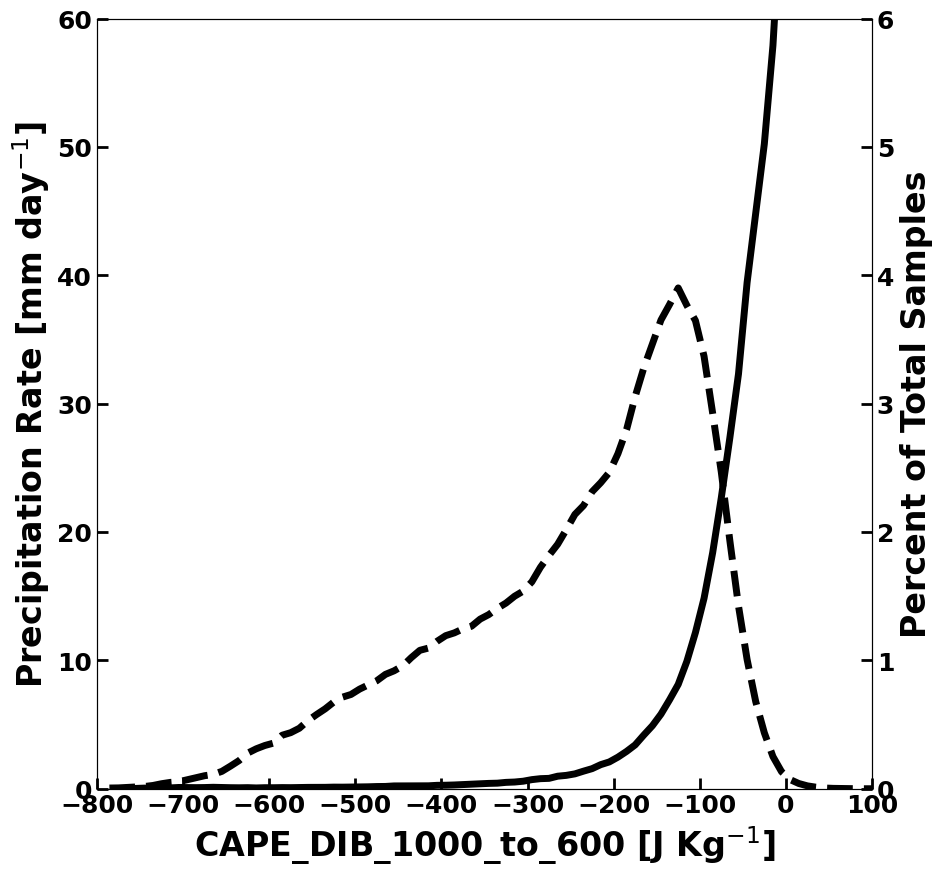

In [20]:
x_axis_limits = (-800, 100)
y_axis_limits = (0, 60)
pdf_axis_limits = (0, 6)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_X_axis_boolean = False
log_Y_axis_boolean = False
plot_pdf_boolean = True
save_fig_boolean = True
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_binned_precipitation_rate_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_one_variable_binned_ivar(precipitation_rate_composite, min_number_of_obs, x_axis_limits, y_axis_limits, pdf_axis_limits, x_axis_label, y_axis_label, pdf_axis_label, log_X_axis_boolean, log_Y_axis_boolean, plot_pdf_boolean, save_fig_boolean, figure_path_and_name)

#### CAPE_DIB_1000_to_600 Binned Precipitation Rate with PDF on Log Scale

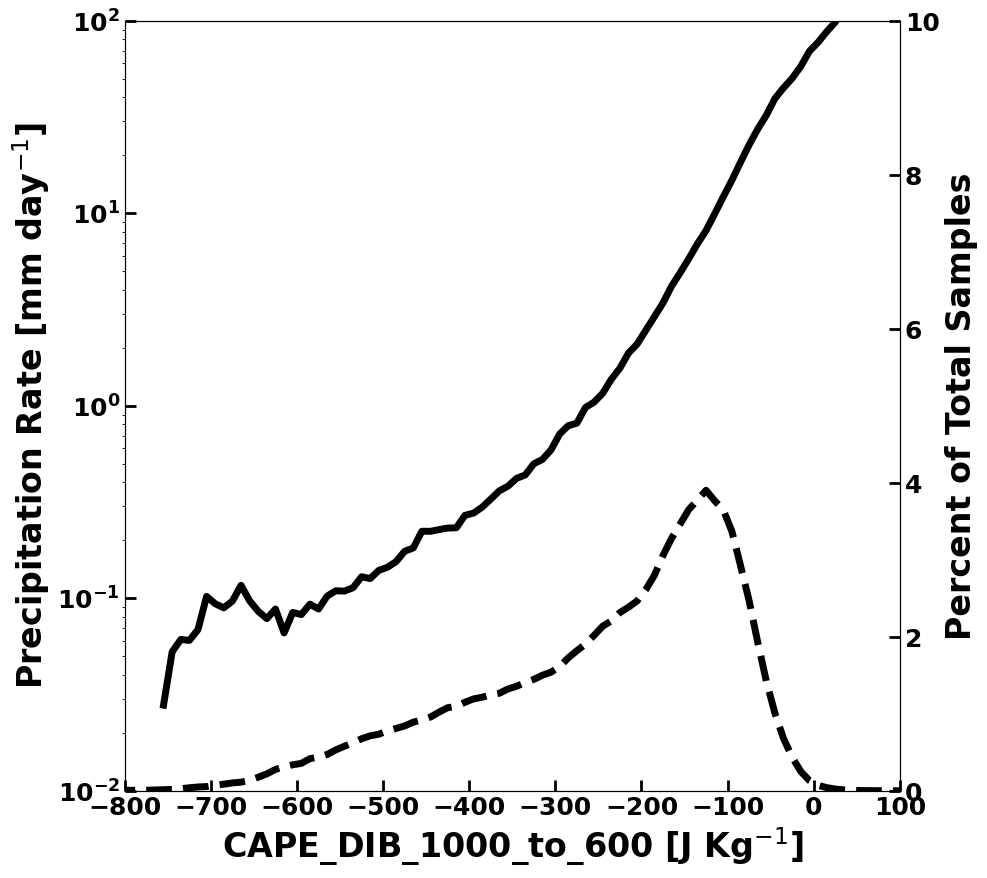

In [19]:
x_axis_limits = (-800, 100)
y_axis_limits = (10**-2, 10**2)
pdf_axis_limits = (0, 10)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_X_axis_boolean = False
log_Y_axis_boolean = True
plot_pdf_boolean = True
save_fig_boolean = True
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_binned_log_precipitation_rate_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_one_variable_binned_ivar(precipitation_rate_composite, min_number_of_obs, x_axis_limits, y_axis_limits, pdf_axis_limits, x_axis_label, y_axis_label, pdf_axis_label, log_X_axis_boolean, log_Y_axis_boolean, plot_pdf_boolean, save_fig_boolean, figure_path_and_name)

## Load and plot CAPE_DIB_1000_to_600-precipitation binned data

In [13]:
CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite_*'), years_to_plot_list))
CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite_*'), years_to_plot_list))

#### Probability of increasing precipitation rate

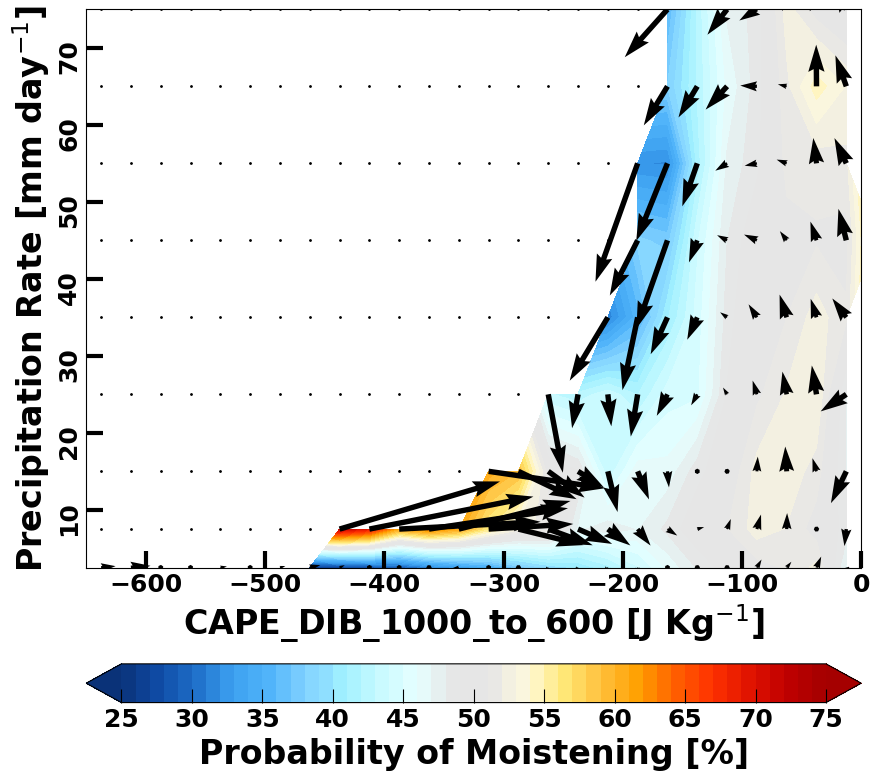

In [18]:
two_variable_binned_coevolution_composites = CAPE_DIB_1000_to_600_precipitation_rate_binned_coevolution_composite
x_axis_limits = (-650, 0)
y_axis_limits = (two_variable_binned_coevolution_composites['bin_number_of_samples_centered'].BV2_bin_midpoint.min(), 75)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = False
color_shading_var = (CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_pos_delta_ivar_centered'] / CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_of_samples_centered'])*100
color_shading_var_number_of_samples = CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(25, 76, 1)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(25, 80, 5)
colorbar_label_string = 'Probability of Moistening [%]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = True
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_precipitation_rate_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


## Load and plot log binbed CAPE_DIB_1000_to_600-precipitation binned data

In [15]:
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite_*'), years_to_plot_list))

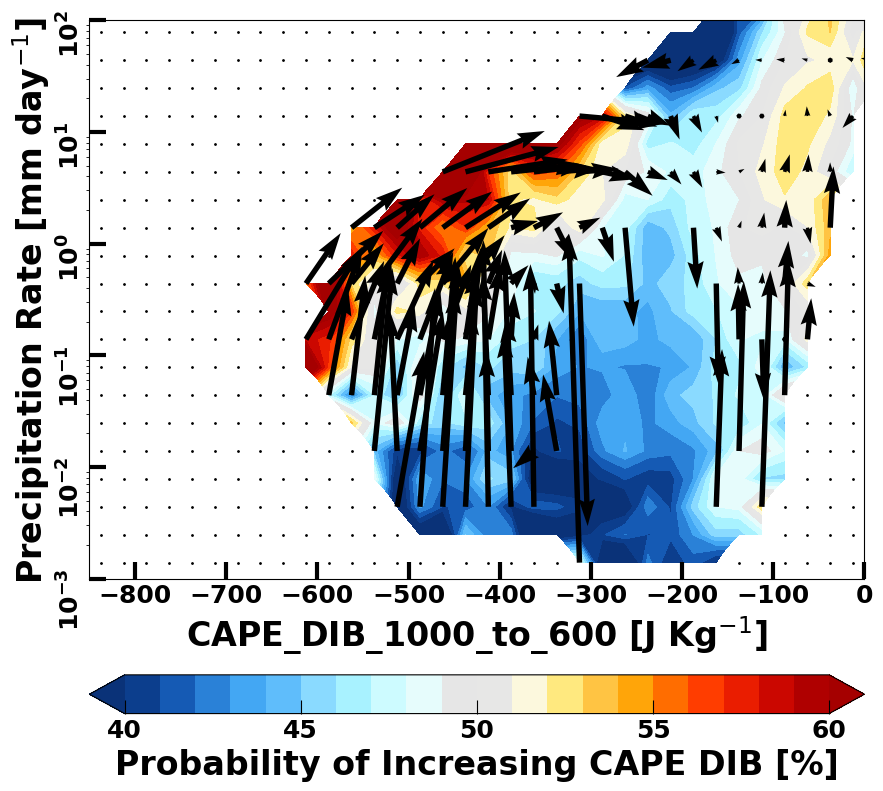

In [17]:
two_variable_binned_coevolution_composites = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (-850, 0)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = (CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_pos_delta_ivar_centered'] / CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered'])*100
color_shading_var_number_of_samples = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(40, 61, 1)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(40, 65, 5)
colorbar_label_string = 'Probability of Increasing CAPE DIB [%]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = True
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)
